The primary goal is to forecast the top 3 best-performing merchants for Q1 2024 and provide a clear data visualization of the results.

"Using python from a database that you build from this data, we want you to help us forecast the top 3 best performing merchants for Q1 2024."

I intepreted the above statement in two ways:

1. What is the forecast for our current top 3 merchants in 2024Q1?
- In this case, our top 3 merchants till date will be identified and their respective transaction amount will be forecasted.

2. Who will be our top 3 merchants in 2024Q1?
- In this case, the transaction amount for all the merchants will be forecasted, and the merchants with the top 3 transaction amount will be identified.

The above statement is slightly ambigious, so I decided to provide answers using both interpretations.

# Import libraries

In [19]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import json
import copy

from ydata_profiling import ProfileReport

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.trend import PolynomialTrendForecaster
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import make_reduction
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sktime.transformations.bootstrap import STLBootstrapTransformer
from sktime.forecasting.compose import BaggingForecaster
from sktime.forecasting.compose import Permute
from sktime.transformations.compose import OptionalPassthrough
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error,mean_absolute_scaled_error,mean_relative_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsoluteError,MeanSquaredError

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
from sktime.transformations.series.detrend import  ConditionalDeseasonalizer
from sktime.transformations.hierarchical.aggregate import Aggregator
from sktime.transformations.series.boxcox import LogTransformer,BoxCoxTransformer
from sktime.transformations.series.scaledlogit import ScaledLogitTransformer
from sktime.transformations.series.exponent import ExponentTransformer,SqrtTransformer


# Import Datasets

In [3]:
#path for each datasets
kard_directory='data/kard_transactions.csv'
external_directory='data/external_transactions.csv'
mapping_directory='data/mapping.csv'

#importing datasets
kard_df=pd.read_csv(kard_directory)
external_df=pd.read_csv(external_directory)
mapping_df=pd.read_csv(mapping_directory)

# Exploratory analysis

In [4]:
#check distribution and missing values
print(kard_df.info())
kard_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1000 non-null   int64 
 1   transactionDate           1000 non-null   object
 2   merchant                  975 non-null    object
 3   transactionAmountinCents  1000 non-null   int64 
 4   issuerId                  1000 non-null   int64 
 5   userId                    1000 non-null   object
 6   transactionStatus         1000 non-null   object
dtypes: int64(3), object(4)
memory usage: 54.8+ KB
None


,id,transactionAmountinCents,issuerId
count,1000.000000,1000.000000,1000.000000
mean,500.500000,4971.405000,15.683000
std,288.819436,2877.230629,8.807161
min,1.000000,-7747.000000,1.000000
25%,250.750000,2453.750000,8.000000
50%,500.500000,4938.500000,15.000000
75%,750.250000,7389.500000,23.000000
max,1000.000000,9988.000000,30.000000


### Detailed EDA with ydata

In [5]:
#detailed EDA of kard dataset with ydata_profiling 
profile_1 = ProfileReport(kard_df)
profile_1.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Summary:
- merchant column has 25 missing values (2.5% of the merchant column & 0.4% of the entire dataset)
- transactionAmountinCents has 2 negative values (0.2% of the column)
- transactionDate is in a JSON format
- transactionAmountinCents should be converted to dollar

In [6]:
#detailed EDA of external dataset with ydata_profiling 
profile_2 = ProfileReport(external_df)
profile_2.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Summary:
- Data contain an invalid date in 2025
- Date column is in a string format, containing '$'.
- Date and Hour column can be merged together and converted to datetime 

# Data cleaning and preprocessing

In [7]:
#functions to clean and merge both datasets

def parse_json_date(json_str):
    """ 
    Given a json, convert to datetime.
    """
    # Extracting date string from the JSON
    date_str = json.loads(json_str)['$date']
    # Parsing the date string into a datetime object
    return datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%S.%fZ")

def parse_datetime(date_str, time_str):
    """ 
    Given a date string and a time string, 
    convert to datetime.
    """
    # Combining date and time strings
    datetime_str = date_str + ' ' + time_str
    # Parsing the combined string into a datetime object
    return datetime.strptime(datetime_str, '%m/%d/%y %H:%M')

def kard_preprocessing(k_df):
    """
    Given the kard dateframe,
    perform all cleaning operations
    """
    #copy dataframe
    df=copy.deepcopy(k_df) 
    #drop missing values in merchant column
    df.dropna(subset=['merchant'],inplace=True) 
    #return absolute values to remove all negatives
    df['transactionAmountinCents']=abs(df.transactionAmountinCents.values) 
    #parse date
    df['transactionDate']=df.transactionDate.apply(parse_json_date) 
    return df

def external_preprocessing(e_df):
    """
    Given the external dateframe,
    perform all cleaning operations
    """
    #copy dataframe
    df=copy.deepcopy(e_df)
    #merge Date and Hour columns then parse
    df['Date']=df.apply(lambda row: parse_datetime(row['Date'], row['Hour']), axis=1)
    #drop Hour column
    df.drop(['Hour'], axis=1, inplace=True) 
    #get index of invalid date
    bad_date_indices=df[df.Date>datetime(2023, 12, 31)].index 
    #remove index of invalid date 
    df.drop(bad_date_indices,inplace=True)
    #format and convert dollar to cent for consistency
    df['dollars']=df.dollars.apply(lambda x: float(x.replace('$', '').replace(',', ''))*100)
    #impute issuerId 31 
    df['issuerId']=[31 for i in df.user]
    return df

def combine_datasets(kard_df,external_df,mapping_df):
    """
    Combine both the kard dataframe and external dataframe using maps from the mapping dataframe
    """
    for kard_col, ext_col in zip(mapping_df['Kard Transactions'], mapping_df['External Transactions']):
        if pd.notna(kard_col) and pd.notna(ext_col):
            external_df.rename(columns={ext_col: kard_col}, inplace=True)
    combined_data_df = pd.concat([kard_df, external_df], ignore_index=True)
    return combined_data_df

In [8]:
#combined datasets ready for analysis
full_df=combine_datasets(kard_preprocessing(kard_df),external_preprocessing(external_df),mapping_df)
full_df

,id,transactionDate,merchant,transactionAmountinCents,issuerId,userId,transactionStatus
0,1,2022-05-12 10:42:20,Scion,8432.0,30,dce4f424-1b58-4bcb-b722-e61194081a6c,APPROVED
1,2,2023-03-30 04:54:36,Rambler,1926.0,9,44448ad8-3b2e-43af-b3b8-8ba49b2637c9,SETTLED
2,3,2023-04-08 10:16:17,Mercedes-Benz,3017.0,12,6f733f54-7d10-4680-871f-a7324d92e681,APPROVED
3,4,2023-07-04 09:21:31,GMC,2866.0,28,b4c2f80c-0bae-4cbe-ab18-d28361c50be1,SETTLED
4,5,2023-03-28 23:53:53,Buick,5934.0,20,b582a67f-77bd-412d-8a0a-eae7a3a4a7b4,APPROVED
...,...,...,...,...,...,...,...
1969,996,2022-12-25 10:45:00,GMC,6518626.0,31,38,SETTLED
1970,997,2023-03-19 21:47:00,BMW,4067916.0,31,8,SETTLED
1971,998,2022-12-31 17:14:00,Land Rover,7396918.0,31,21,SETTLED
1972,999,2023-07-11 15:42:00,Pontiac,6162027.0,31,5,SETTLED


In [172]:
#Ingest full data into database
import sqlite3 #sqlite chosen per memory considerations
to_sql_full_df = full_df.applymap(str)
connection = sqlite3.connect('combined_data.db')
to_sql_full_df.to_sql('combined_data', con=connection, if_exists='replace', index=False)
connection.close()


# 1. What is the forecast for our current top 3 merchants in 2024Q1?
- In this case, our top 3 merchants till date will be identified and their respective transaction amount will be forecasted.

## Analsysis

In [9]:
#prepare data for sktime forcast
full_df['quarter'] = pd.PeriodIndex(full_df['transactionDate'] ,freq='Q')# create quarter column for each datetime
three_col_df=full_df.groupby(['merchant', 'quarter'])['transactionAmountinCents'].sum().reset_index()
three_col_df

,merchant,quarter,transactionAmountinCents
0,Acura,2022Q2,18186.0
1,Acura,2022Q3,11297004.0
2,Acura,2022Q4,28951781.0
3,Acura,2023Q1,4054588.0
4,Acura,2023Q2,48002343.0
...,...,...,...
269,Volvo,2022Q3,43380.0
270,Volvo,2022Q4,31082940.0
271,Volvo,2023Q1,41907798.0
272,Volvo,2023Q2,22938008.0


In [10]:
#top 3 performing merchants
three_col_df.groupby(['merchant'])['transactionAmountinCents'].sum().sort_values(ascending=False).reset_index()

,merchant,transactionAmountinCents
0,Suzuki,5.350000e+22
1,Ford,4.257624e+08
2,Chevrolet,3.637918e+08
3,Toyota,2.312783e+08
4,BMW,2.123208e+08
...,...,...
58,Holden,7.593000e+03
59,Tesla,5.488000e+03
60,Alfa Romeo,3.819000e+03
61,Renault,3.694000e+03


The top 3 performing merchants are Suzuki,Ford,Chevrolet

# Forecast model

In [11]:
#prepare top 3 merchant for forecast in sktime
top_perform_df=three_col_df[three_col_df.merchant.isin(['Suzuki', 'Ford','Chevrolet'])]
top_perform_df.set_index(['merchant','quarter'],inplace=True)

In [12]:
#split data into train and validation
y_train=top_perform_df[top_perform_df.index.get_level_values(1)!=pd.Period('2023Q3', freq='Q')]
y_test=top_perform_df.drop(y_train.index)

In [13]:
y_train

transactionAmountinCents
merchant  quarter                          
Chevrolet 2022Q2               4.390700e+04
          2022Q3               7.763865e+06
          2022Q4               1.434692e+08
          2023Q1               1.143058e+08
          2023Q2               6.878611e+07
Ford      2022Q2               4.975500e+04
          2022Q3               1.415094e+07
          2022Q4               1.154958e+08
          2023Q1               1.083982e+08
          2023Q2               1.570427e+08
Suzuki    2022Q2               3.624000e+03
          2022Q3               6.351550e+06
          2022Q4               5.350000e+22
          2023Q1               2.155010e+07
          2023Q2               3.506128e+06

In [14]:
y_test

,,transactionAmountinCents
merchant,quarter,
Chevrolet,2023Q3,29422945.0
Ford,2023Q3,30625008.0


Please note Suzuki has no data for 2023Q3. Therefore all forcast will be made using data from 2022Q2 to 2023Q2.

2023Q3 data will be used for validation only.

### Crossvalidation using gridsearch

In [20]:
#prepare forecast horizon and cross validation
fh=np.array([1,2,3]) 

cv = SlidingWindowSplitter(window_length=4, step_length=1)



pipe_y = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer_1", OptionalPassthrough(Deseasonalizer(model="multiplicative", sp=1))),
        ("deseasonalizer_2", OptionalPassthrough(Deseasonalizer(model="multiplicative", sp=2))),
        ("transformer", OptionalPassthrough(TabularToSeriesAdaptor(ExponentTransformer()))),
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("detrender", OptionalPassthrough(Detrender(forecaster=PolynomialTrendForecaster(degree=1)))),
        ("forecaster", STLForecaster(sp=2))
    ]
)

param_grid = {
    
    "deseasonalizer_1__passthrough": [True, False],
    "deseasonalizer_2__passthrough": [True, False],
    "transformer__passthrough": [True, False],
    "scaler__passthrough": [True, False],
    "detrender__passthrough": [True, False],
    "forecaster":[STLForecaster(sp=2),AutoARIMA(suppress_warnings=True),ExponentialSmoothing(sp=2),NaiveForecaster(sp=2,strategy='drift')
                 ,Prophet(seasonality_mode='multiplicative',n_changepoints=int(len(y_train) / 2),
                         add_country_holidays={'country_name': 'USA'},yearly_seasonality=False),
                 AutoETS(auto=True, sp=2,n_jobs=-1),BATS(sp=2, use_trend=True, use_box_cox=False),
                  make_reduction(XGBRegressor(n_jobs=-1),scitype='tabular-regressor', window_length=3),
                 ]
    
            }

gscv = ForecastingGridSearchCV(
    forecaster=pipe_y,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    scoring=MeanSquaredError(square_root=True),
    error_score="raise",
)

gscv.fit(y=y_train)
gscv.best_forecaster_

Fitting 11 folds for each of 256 candidates, totalling 2816 fits


TransformedTargetForecaster(steps=[('deseasonalizer_1',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=Deseasonalizer(model='multiplicative'))),
                                   ('deseasonalizer_2',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=Deseasonalizer(model='multiplicative',
                                                                                   sp=2))),
                                   ('transformer',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=TabularToSeriesAdaptor(transformer=ExponentTransformer()))),
                                   ('scaler',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=TabularToSeriesAdaptor(transformer=StandardScaler()))),
                                   ('detrender',
                                    OptionalPassthrough(passthrough=True,
                                                        transformer=Detrender(forecaster=PolynomialTrendForecaster()))),
                                   ('forecaster',
                                    AutoARIMA(suppress_warnings=True))])

In [21]:
#re-construct best forcaster
forecaster =  Deseasonalizer(model="multiplicative", sp=1) *Deseasonalizer(model="multiplicative", sp=2)* ExponentTransformer()* StandardScaler()*Detrender(forecaster=PolynomialTrendForecaster(degree=1)) * AutoARIMA(sp=1,suppress_warnings=True,maxiter=200,                                                                                                                                                                       
                                                                                                                                                                                                    start_p=0, d=1, start_q=0,
                                                                                                                                                                                                   max_p=3, max_d=2, max_q=3,
                                                                                                                                                                                                   start_P=0, D=1, start_Q=0,
                                                                                                                                                                                                   max_P=3, max_D=2, max_Q=3,
                                                                                                                                                                                                   error_action='warn',trace = True,)
forecaster


TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative'),
                                   Deseasonalizer(model='multiplicative', sp=2),
                                   ExponentTransformer(),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   Detrender(forecaster=PolynomialTrendForecaster()),
                                   AutoARIMA(D=1, d=1, max_D=2, max_P=3,
                                             max_Q=3, max_p=3, max_q=3,
                                             maxiter=200, start_P=0, start_Q=0,
                                             start_p=0, start_q=0,
                                             suppress_warnings=True,
                                             trace=True)])

In [22]:
forecaster.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15.750, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17.746, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.821, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.178 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.246, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.230, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.139, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.290, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15.131, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.138 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.723, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)

TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative'),
                                   Deseasonalizer(model='multiplicative', sp=2),
                                   ExponentTransformer(),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   Detrender(forecaster=PolynomialTrendForecaster()),
                                   AutoARIMA(D=1, d=1, max_D=2, max_P=3,
                                             max_Q=3, max_p=3, max_q=3,
                                             maxiter=200, start_P=0, start_Q=0,
                                             start_p=0, start_q=0,
                                             suppress_warnings=True,
                                             trace=True)])

In [23]:
y_pred = forecaster.predict(fh)
y_pred

transactionAmountinCents
merchant  quarter                          
Chevrolet 2023Q3               5.414254e+07
          2023Q4               1.935757e+08
          2024Q1               1.228129e+08
Ford      2023Q3               1.244605e+08
          2023Q4               3.746457e+08
          2024Q1               2.538022e+08
Suzuki    2023Q3               4.502805e+04
          2023Q4               3.453559e+20
          2024Q1               4.052523e+05

In [24]:
def concatenate_rows(y_train, y_pred):
    """
    Concatenates the last row of each merchant in y_train with the first row of each merchant in y_pred.

    """
    concatenated_df = pd.DataFrame()
    merchants = y_train.index.get_level_values('merchant').unique()

    for merchant in merchants:
        # Extract the last row for this merchant from y_train
        last_row_train = y_train.loc[(merchant, slice(None)), :].iloc[-1:]

        # Extract the first row for this merchant from y_pred
        first_row_pred = y_pred.loc[(merchant, slice(None)), :].iloc[:1]

        # Concatenate and append to the final DataFrame
        concatenated_df = pd.concat([concatenated_df, last_row_train, first_row_pred])

    return concatenated_df

#connect historical and forecast data in visualization
plot_connector_df=concatenate_rows(y_train, y_pred)
plot_connector_df

transactionAmountinCents
merchant  quarter                          
Chevrolet 2023Q2               6.878611e+07
          2023Q3               5.414254e+07
Ford      2023Q2               1.570427e+08
          2023Q3               1.244605e+08
Suzuki    2023Q2               3.506128e+06
          2023Q3               4.502805e+04

In [25]:
#prediction intervals
pred_intervalss=forecaster.predict_interval(coverage=0.98)
pred_intervalss

/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 

Coverage              
                           0.98              
                          lower         upper
merchant  quarter                            
Chevrolet 2023Q3   3.247965e+06  2.728962e+08
          2023Q4   3.177519e+07  1.119839e+09
          2024Q1   2.290138e+07  7.263092e+08
Ford      2023Q3   3.567269e+07  2.669863e+08
          2023Q4   7.884232e+07  8.899611e+08
          2024Q1   4.834475e+07  6.204733e+08
Suzuki    2023Q3   4.594705e+07  5.188064e+07
          2023Q4   1.716623e+23  2.038423e+23
          2024Q1   1.315958e+08  1.624276e+08

### Forecast visualization

<Figure size 432x288 with 0 Axes>

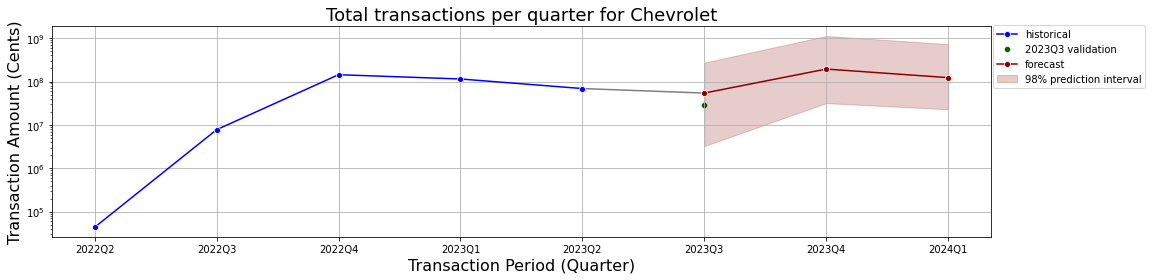

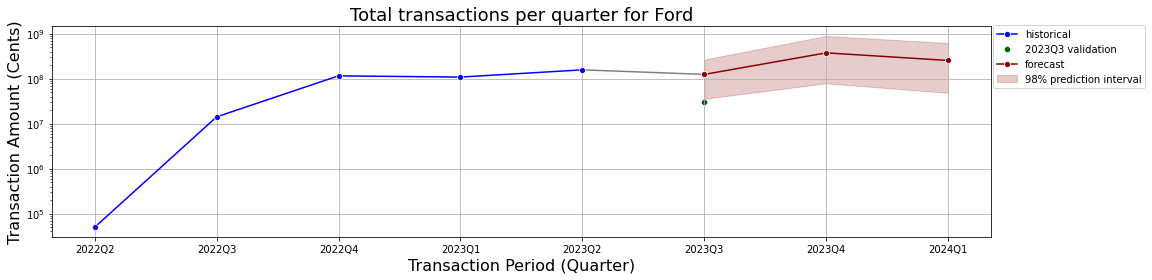

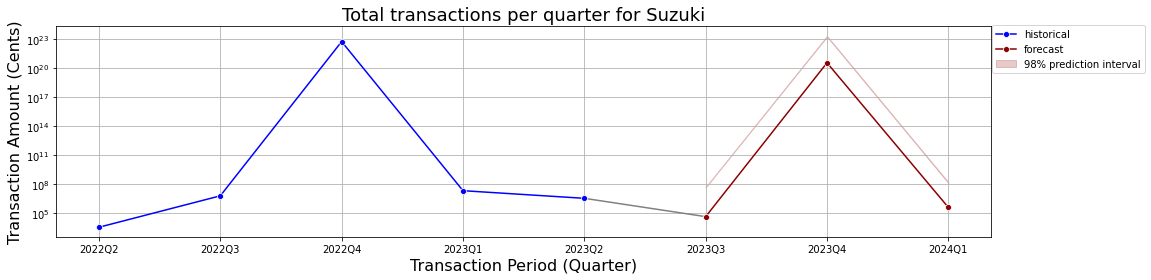

In [111]:
%matplotlib inline
plt.figure()

for r in ['Chevrolet','Ford','Suzuki']:
    if r !='Suzuki':
        plot_series(plot_connector_df[plot_connector_df.index.get_level_values(0)==r].droplevel(0),
                    y_train[y_train.index.get_level_values(0)==r].droplevel(0),
                    y_test[y_test.index.get_level_values(0)==r].droplevel(0),
                    y_pred[y_pred.index.get_level_values(0)==r].droplevel(0),
                    pred_interval=pred_intervalss[pred_intervalss.index.get_level_values(0)==r].droplevel(0),
                    labels=["","historical","2023Q3 validation","forecast"],colors=['grey','blue','darkgreen','darkred'])
    else:
        plot_series(plot_connector_df[plot_connector_df.index.get_level_values(0)==r].droplevel(0),
                    y_train[y_train.index.get_level_values(0)==r].droplevel(0),
                    y_pred[y_pred.index.get_level_values(0)==r].droplevel(0),
                    pred_interval=pred_intervalss[pred_intervalss.index.get_level_values(0)==r].droplevel(0),
                    labels=["","historical","forecast"],colors=['grey','blue','darkred'],)
    plt.plot()
    plt.legend(bbox_to_anchor=(1.17, 1.03))
    plt.grid(True)
    plt.yscale('log')
    plt.title('Total transactions per quarter for '+r, fontsize=18)
    plt.xlabel('Transaction Period (Quarter)',fontsize=16)
    plt.ylabel('Transaction Amount (Cents)',fontsize=16)
    plt.tight_layout()
    #plt.savefig('images/kard_forcast_' + r +'.png',dpi=600)

In [27]:
#metrics
for i in ['Chevrolet','Ford']:
    mae=mean_absolute_scaled_error(y_test[y_test.index.get_level_values(0)==i].droplevel(0),
                                   y_pred[y_pred.index.get_level_values(0)==i].droplevel(0).iloc[0],y_train=y_train[y_train.index.get_level_values(0)==i].droplevel(0),)
    print(i,mae)

Chevrolet 0.45334500011525947
Ford 2.1925726886608836


This is because only Chevrolet and Ford has 2023Q3 data

# 2. Who will be our top 3 merchants in 2024Q1?
- In this case, the transaction amount for all the merchants will be forecasted, and the merchants with the top 3 transaction amount will be identified.

In [36]:
k=three_col_df.set_index(['merchant','quarter'])

In [37]:
k

transactionAmountinCents
merchant quarter                          
Acura    2022Q2                    18186.0
         2022Q3                 11297004.0
         2022Q4                 28951781.0
         2023Q1                  4054588.0
         2023Q2                 48002343.0
...                                    ...
Volvo    2022Q3                    43380.0
         2022Q4                 31082940.0
         2023Q1                 41907798.0
         2023Q2                 22938008.0
         2023Q3                 12306159.0

[274 rows x 1 columns]

In [112]:
#Using the same final forcaster as above
forecaster_ =  Deseasonalizer(model="multiplicative", sp=1) *Deseasonalizer(model="multiplicative", sp=2)* ExponentTransformer()* StandardScaler()*Detrender(forecaster=PolynomialTrendForecaster(degree=1)) * AutoARIMA(sp=1,suppress_warnings=True,maxiter=200,                                                                                                                                                                       
                                                                                                                                                                                                    start_p=0, d=1, start_q=0,
                                                                                                                                                                                                   max_p=3, max_d=2, max_q=3,
                                                                                                                                                                                                   start_P=0, D=1, start_Q=0,
                                                                                                                                                                                                   max_P=3, max_D=2, max_Q=3,)
                                                                                                                                                                                                   #error_action='warn',trace = False,)
forecaster_


TransformedTargetForecaster(steps=[Deseasonalizer(model='multiplicative'),
                                   Deseasonalizer(model='multiplicative', sp=2),
                                   ExponentTransformer(),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   Detrender(forecaster=PolynomialTrendForecaster()),
                                   AutoARIMA(D=1, d=1, max_D=2, max_P=3,
                                             max_Q=3, max_p=3, max_q=3,
                                             maxiter=200, start_P=0, start_Q=0,
                                             start_p=0, start_q=0,
                                             suppress_warnings=True)])

In [146]:
pred_list=[]
pred_int_list=[]
for i in k.index.get_level_values(0).unique():
    subset=k[k.index.get_level_values(0)==i].droplevel(0)
    try:
        forecaster_.fit(subset)
        q_diff=pd.Period('2024Q1')-k.loc[(i, slice(None)), :].iloc[-1:].index.get_level_values(1)
        fh_=np.array([i+1 for i in range(q_diff[0].n)])
        y_pred_full=forecaster_.predict(fh_)
        y_pred_full['merchant']=i
        pred_list.append(y_pred_full)
        pred_intervalss_full=forecaster_.predict_interval(coverage=0.98)
        pred_intervalss_full['merchant']=i
        pred_int_list.append(pred_intervalss_full)
    except ValueError:
        pass
    
#full forcasts    
full_forcast_df = pd.concat(pred_list)   
full_forcast_df.index.name='quarter'
full_forcast_df=full_forcast_df.reset_index()
full_forcast_df=full_forcast_df.set_index(['merchant','quarter'])

#full_prediction_intervals
full_forcast_pred_int = pd.concat(pred_int_list)   
full_forcast_pred_int.index.name='quarter'
full_forcast_pred_int=full_forcast_pred_int.reset_index()
full_forcast_pred_int=full_forcast_pred_int.set_index(['merchant','quarter'])
full_forcast_pred_int

/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 

/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 

/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 0.22.0, predict_interval return default column level 0 name will change for univariate probabilistic interval forecasts from 'Coverage' to variable name. The old behaviour can be retained by setting the legacy_interface argument to True, until 0.23.0 when the legacy_interface argument will be removed.
  warn(
/usr/local/Caskroom/miniconda/base/envs/Cat/lib/python3.8/site-packages/sktime/forecasting/base/_base.py:683: UserWarning: In 

Coverage              
                              0.98              
                             lower         upper
merchant     quarter                            
Acura        2023Q4   9.952407e+07  1.072278e+08
             2024Q1   6.113913e+07  6.492351e+07
Aston Martin 2023Q4   1.857765e+07  2.444298e+07
             2024Q1   7.545298e+07  1.102781e+08
Audi         2023Q4   3.833205e+07  4.830088e+07
...                            ...           ...
Toyota       2024Q1   5.738256e+07  1.497184e+08
Volkswagen   2023Q4   1.095366e+07  1.876587e+08
             2024Q1   1.698158e+07  1.683325e+08
Volvo        2023Q4   1.923521e+06  1.649007e+08
             2024Q1   5.998103e+06  1.653827e+08

[110 rows x 2 columns]

In [148]:
#Top 3 forecasted merchants
pivot_df = full_forcast_df.reset_index().pivot(index='merchant', columns='quarter', values='transactionAmountinCents')


sorted_pivot_df = pivot_df.sort_values(by='2024Q1', ascending=False)

sorted_df = sorted_pivot_df.stack().reset_index(name='transactionAmountinCents')
sorted_df = sorted_df.set_index(['merchant', 'quarter'])

sorted_df.head(40)


transactionAmountinCents
merchant      quarter                          
Oldsmobile    2023Q3               2.247998e+09
              2023Q4               3.110707e+07
              2024Q1               4.007415e+09
Mercedes-Benz 2023Q3               6.782049e+07
              2023Q4               1.498784e+08
              2024Q1               1.436936e+08
Ford          2023Q4               9.750210e+07
              2024Q1               6.526653e+07
Chevrolet     2023Q4               8.187555e+07
              2024Q1               5.767996e+07
Plymouth      2023Q3               2.973296e+07
              2023Q4               2.451545e+07
              2024Q1               5.496172e+07
Pontiac       2023Q4               2.258576e+07
              2024Q1               5.167503e+07
Nissan        2023Q4               5.722686e+07
              2024Q1               4.918523e+07
Lexus         2023Q4               5.220064e+07
              2024Q1               2.963093e+07
Jaguar        2023Q3               1.373011e+07
              2023Q4               6.480099e+07
              2024Q1               2.853061e+07
Volvo         2023Q4               3.279367e+07
              2024Q1               2.709509e+07
BMW           2023Q4               3.201739e+07
              2024Q1               2.702651e+07
Saab          2023Q4               8.510931e+06
              2024Q1               2.130434e+07
Hummer        2023Q4               7.118786e+06
              2024Q1               1.977520e+07
Volkswagen    2023Q4               2.697876e+07
              2024Q1               1.959399e+07
Lincoln       2023Q4               3.233475e+07
              2024Q1               1.922503e+07
Infiniti      2023Q3               7.921445e+06
              2023Q4               6.605233e+07
              2024Q1               1.848480e+07
Buick         2023Q4               8.166755e+07
              2024Q1               1.837557e+07
Chrysler      2023Q4               5.156961e+06

The top 3 forecasted merchants for 2024Q1 are: Oldsmobile, Mercedes-Benz,and Ford

In [149]:
#Plot connectors
plot_connector_df_2=concatenate_rows(k[k.index.get_level_values(0).isin(['Oldsmobile', 'Mercedes-Benz', 'Ford'])], full_forcast_df[full_forcast_df.index.get_level_values(0).isin(['Oldsmobile', 'Mercedes-Benz', 'Ford'])])
plot_connector_df_2

transactionAmountinCents
merchant      quarter                          
Ford          2023Q3               3.062501e+07
              2023Q4               9.750210e+07
Mercedes-Benz 2023Q2               5.928640e+07
              2023Q3               6.782049e+07
Oldsmobile    2023Q2               1.581133e+07
              2023Q3               2.247998e+09

<Figure size 432x288 with 0 Axes>

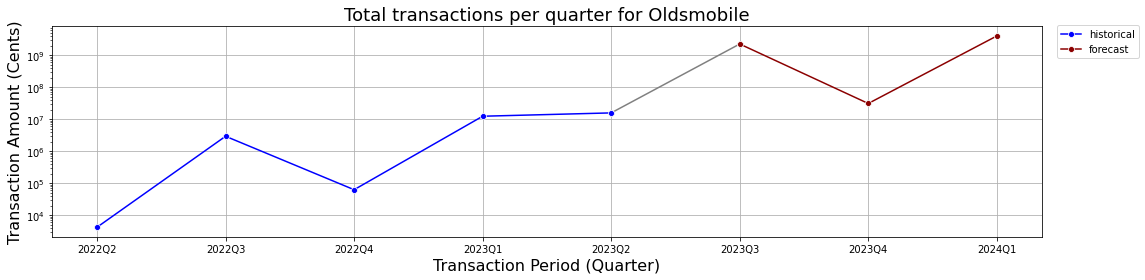

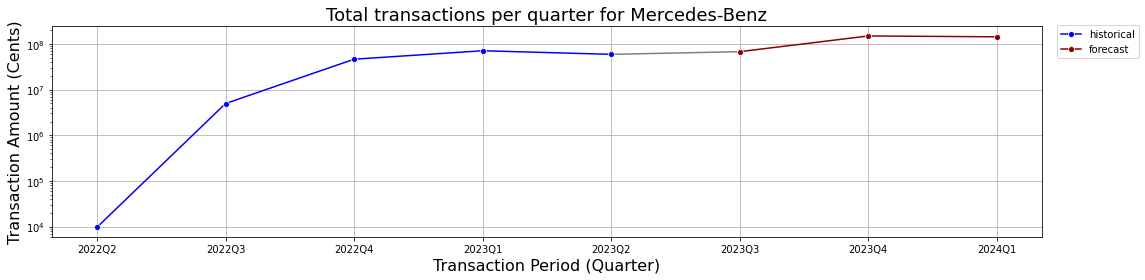

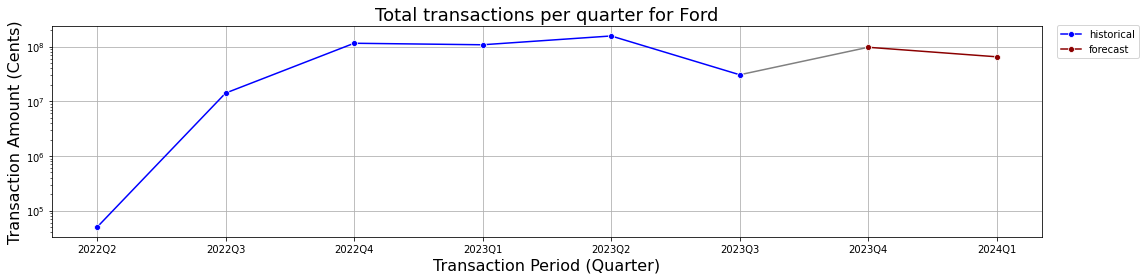

In [168]:
%matplotlib inline
plt.figure()

for r in ['Oldsmobile', 'Mercedes-Benz', 'Ford']:
   
    plot_series(
                plot_connector_df_2[plot_connector_df_2.index.get_level_values(0)==r].droplevel(0),
                k[k.index.get_level_values(0)==r].droplevel(0),
                full_forcast_df[full_forcast_df.index.get_level_values(0)==r].droplevel(0),
                #pred_interval=full_forcast_pred_int[full_forcast_pred_int.index.get_level_values(0)==r].droplevel(0),
                labels=["","historical","forecast"],colors=['grey','blue','darkred'])

    plt.plot()
    plt.legend(bbox_to_anchor=(1.01, 1.03))
    plt.grid(True)
    plt.yscale('log')
    plt.title('Total transactions per quarter for '+r, fontsize=18)
    plt.xlabel('Transaction Period (Quarter)',fontsize=16)
    plt.ylabel('Transaction Amount (Cents)',fontsize=16)
    plt.tight_layout()
    plt.savefig('images/kard_forcast_2' + r +'.png',dpi=600)